# Time series forecasing for network traffic dataset

In this notebook, we will show how to use Analytics Zoo to do time series forecasting.

The dataset we use is the aggregated network traffic traces at the transit link of WIDE to the upstream ISP (You can find the data [here](http://mawi.wide.ad.jp/~agurim/dataset/)). We use its monthly aggregated data of year 2018 and 2019 to do time series forecasting. The monthly aggregated data is collected at 2-hour interval.

To download data, you can run `get_data.sh`. It will download all the monthly aggregated data of 2018 and 2019 into `data`. 

The raw data contains full network traffic logs. To extract values which can indicate network traffic status (eg. `AvgRate` and `total`), you can run `extract_data.sh`. It will extract the useful values into data.csv in your `data` folder. 

## Helper functions

In [1]:
def get_drop_dates_and_len(df, allow_missing_num=3):
    """
    Find missing values and get records to drop
    """
    full_idx = pd.date_range(start=df.index.min(), end=df.index.max(), freq='2H')
    df = df.reindex(full_idx)
    missing_num = df.total.isnull().astype(int).groupby(df.total.notnull().astype(int).cumsum()).sum()
    drop_missing_num = missing_num[missing_num > allow_missing_num]
    drop_datetimes = df.iloc[drop_missing_num.index].index
    print(drop_datetimes)
    drop_len = drop_missing_num.values
    return drop_datetimes, drop_len

In [2]:
def rm_missing_weeks(start_dts, missing_lens, df):
    """
    Drop weeks that contains more than 3 consecutive missing values.
    If consecutive missing values across weeks, we remove all the weeks.
    """ 
    for start_time, l in zip(start_dts, missing_lens):
        start = start_time - pd.Timedelta(days=start_time.dayofweek)
        start = start.replace(hour=0, minute=0, second=0)
        start_week_end = start + pd.Timedelta(days=6)
        start_week_end = start_week_end.replace(hour=22, minute=0, second=0)

        end_time = start_time + l*pd.Timedelta(hours=2)
        if start_week_end < end_time:
            end = end_time + pd.Timedelta(days=6-end_time.dayofweek)
            end = end.replace(hour=22, minute=0, second=0)
        else:
            end = start_week_end
        df = df.drop(df[start:end].index)
    return df

In [3]:
def gen_dataset_matrix(dataset, look_back, target_col_indexes):
    """
    Generate input samples from rolling
    """
    X, Y = [], []
    if len(target_col_indexes) == 1:
        del_col_index = {0, 1}.difference(set(target_col_indexes)).pop()
        data = np.delete(dataset, del_col_index, axis=1)
    else:
        data = dataset
    for i in range(len(data)-look_back-1):
        X.append(data[i: (i + look_back)])
        Y.append(data[i + look_back, target_col_indexes])
    return np.array(X), np.array(Y)

In [4]:
def unscale(scaler, y, target_col_indexes):
    """
    data needs to be normalized (scaled) before feeding into models. 
    This is to inverse the effect of normlization to get reasonable forecast results.
    """
    dummy_feature_shape = scaler.scale_.shape[0]
    y_dummy = np.zeros((y.shape[0], dummy_feature_shape))
    y_dummy[:, target_col_indexes] = y
    y_unscale = scaler.inverse_transform(y_dummy)[:,target_col_indexes]
    return y_unscale

In [5]:
EPSILON = 1e-10
def sMAPE(y_true, y_pred):
    """
    Symmetric Mean Average Percentage Error
    """
    output_errors = np.mean(100 * np.abs(y_true - y_pred)/(np.abs(y_true) + np.abs(y_pred) + EPSILON), axis=0,)
    return np.mean(output_errors)

In [6]:
def plot_predict_actual_values(date, y_pred, y_test, ylabel):
    """
    plot the predicted values and actual values (for the test data)
    """
    fig, axs = plt.subplots(figsize=(16,6))

    axs.plot(date, y_pred,color='red', label='predicted values')
    axs.plot(date, y_test,color='blue', label='actual values')
    axs.set_title('the predicted values and actual values (for the test data)')

    plt.xlabel('test datetime')
    plt.ylabel(ylabel)
    plt.legend(loc='upper left')
    plt.show()

## Read raw dataset 

In [7]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
raw_df = pd.read_csv("data/data.csv")

In [9]:
raw_df.head()

,StartTime,EndTime,AvgRate,total
0,2018/01/01 00:00:00,2018/01/01 02:00:00,306.23Mbps,275605455598
1,2018/01/01 02:00:00,2018/01/01 04:00:00,285.03Mbps,256527692256
2,2018/01/01 04:00:00,2018/01/01 06:00:00,247.39Mbps,222652190823
3,2018/01/01 06:00:00,2018/01/01 08:00:00,211.55Mbps,190396029658
4,2018/01/01 08:00:00,2018/01/01 10:00:00,234.82Mbps,211340468977


## Data pre-processing

Data pre-processing should contain the below steps:  
1. Convert string datetime to TimeStamp
2. Unify `AvgRate` value since it contains different scales
3. Drop missing data and fill.

In [10]:
df = pd.DataFrame(pd.to_datetime(raw_df.StartTime))

In [11]:
# we can find 'AvgRate' is of two scales: 'Mbps' and 'Gbps' 
raw_df.AvgRate.str[-4:].unique()

array(['Mbps', 'Gbps'], dtype=object)

In [12]:
# Unify AvgRate value
df['AvgRate'] = raw_df.AvgRate.apply(lambda x: float(x[:-4]) if x.endswith("Mbps") else float(x[:-4]) * 1000)

In [13]:
df["total"] = raw_df["total"]
df.set_index("StartTime", inplace=True)

In [14]:
df.head()

,AvgRate,total
StartTime,,
2018-01-01 00:00:00,306.23,275605455598
2018-01-01 02:00:00,285.03,256527692256
2018-01-01 04:00:00,247.39,222652190823
2018-01-01 06:00:00,211.55,190396029658
2018-01-01 08:00:00,234.82,211340468977


In [15]:
full_idx = pd.date_range(start=df.index.min(), end=df.index.max(), freq='2H')
resample_df = df.reindex(full_idx)
print("no. of n/a values:")
print(resample_df.isna().sum())

no. of n/a values:
AvgRate    3
total      3
dtype: int64


Here, we drop weeks with more than 3 consecutive missing values and fill other missing values remained.

In [16]:
drop_dts, drop_len = get_drop_dates_and_len(df)
df = rm_missing_weeks(drop_dts, drop_len, df)

DatetimeIndex([], dtype='datetime64[ns]', freq='2H')


In [17]:
df.ffill(inplace=True)

Visualization

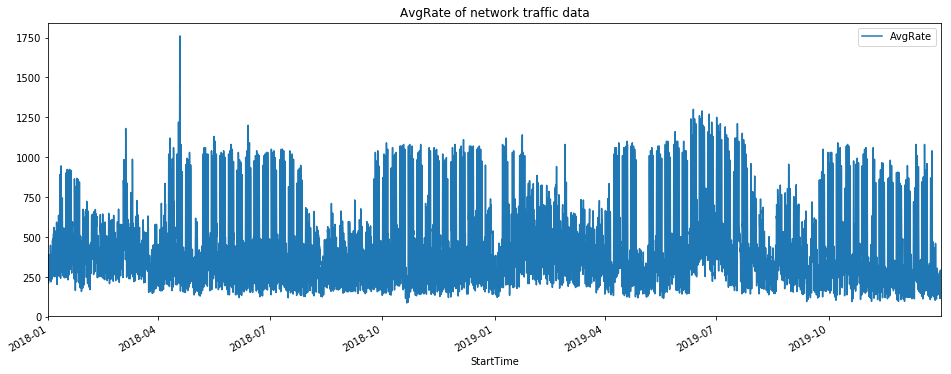

In [18]:
ax = df.plot(y='AvgRate',figsize=(16,6), title="AvgRate of network traffic data")

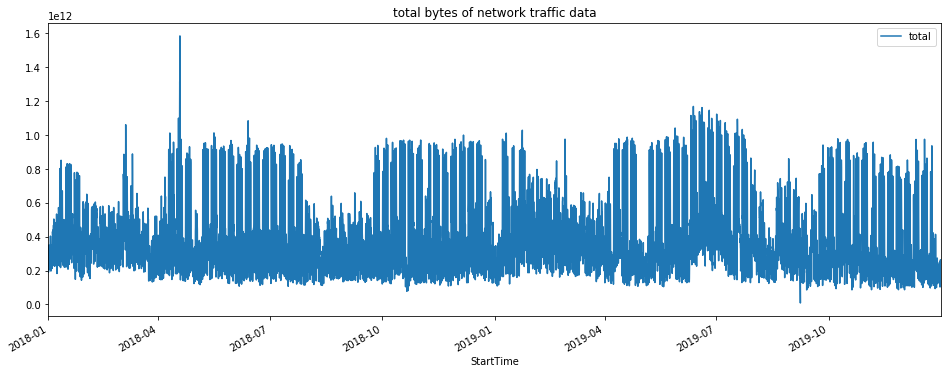

In [19]:
ax = df.plot(y='total',figsize=(16,6), title="total bytes of network traffic data")

## Feature Engineering

Extract some useful datetime features.

In [20]:
df["year"] = df.index.year
df["month"] = df.index.month
df["week"] = df.index.week
df["dayofweek"] = df.index.dayofweek
df["hour"] = df.index.hour

In [21]:
df.head()

,AvgRate,total,year,month,week,dayofweek,hour
StartTime,,,,,,,
2018-01-01 00:00:00,306.23,275605455598,2018,1,1,0,0
2018-01-01 02:00:00,285.03,256527692256,2018,1,1,0,2
2018-01-01 04:00:00,247.39,222652190823,2018,1,1,0,4
2018-01-01 06:00:00,211.55,190396029658,2018,1,1,0,6
2018-01-01 08:00:00,234.82,211340468977,2018,1,1,0,8


## Data preparation

First, split dataset into train and test set

In [22]:
test_num = 1000
# we look back one week data which is of the frequency of 2h.
look_back = 84
test_split_index = test_num + look_back + 1
horizon = 1

#train_df
train_df = df[:-test_num]
test_df = df[-test_split_index:]
test_df = test_df.reset_index(drop=True)

Then standardize train, test data and featues

In [23]:
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
scaled_train = standard_scaler.fit_transform(train_df)
scaled_test = standard_scaler.transform(test_df)

Last, we generate data matrix by sliding window along time axis


* univariate data

In [24]:
# for univeriate
# here we take "AvgRate" as an example
uni_target_col_indexes = [0]
uni_target_value = "AvgRate"

x_train, y_train = gen_dataset_matrix(scaled_train, look_back, uni_target_col_indexes)
x_test, y_test = gen_dataset_matrix(scaled_test, look_back, uni_target_col_indexes)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((7675, 84, 6), (7675, 1), (1000, 84, 6), (1000, 1))

* multi

In [25]:
# for multivariate
multi_target_col_indexes = [0, 1]
multi_target_value = ["AvgRate","total"]

x_train_m, y_train_m = gen_dataset_matrix(scaled_train, look_back, multi_target_col_indexes)
x_test_m, y_test_m = gen_dataset_matrix(scaled_test, look_back, multi_target_col_indexes)
x_train_m.shape, y_train_m.shape, x_test_m.shape, y_test_m.shape

((7675, 84, 7), (7675, 2), (1000, 84, 7), (1000, 2))

# Time series forecasting 

### Univariate forecasting
We take LSTM model as an example.

In [36]:
from zoo.zouwu.model.forecast import LSTMForecaster

In [27]:
# build model
forecaster = LSTMForecaster(horizon=horizon, feature_dim=x_train.shape[-1])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [28]:
%%time
forecaster.fit(x=x_train, y=y_train, batch_size=32, epochs=10, distributed=False)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 7675 samples
Epoch 1/10
7675/7675 [==============================] - 13s 2ms/sample - loss: 0.6921 - mean_squared_error: 0.6921
Epoch 2/10
7675/7675 [==============================] - 13s 2ms/sample - loss: 0.3558 - mean_squared_error: 0.3558
Epoch 3/10
7675/7675 [==============================] - 13s 2ms/sample - loss: 0.2595 - mean_squared_error: 0.2595
Epoch 4/10
7675/7675 [==============================] - 13s 2ms/sample - loss: 0.2172 - mean_squared_error: 0.2172
Epoch 5/10
7675/7675 [==============================] - 13s 2ms/sample - loss: 0.1937 - mean_squared_error: 0.1937
Epoch 6/10
7675/7675 [==============================] - 13s 2ms/sample - loss: 0.1803 - mean_squared_error: 0.1803
Epoch 7/10
7675/7675 [==============================] - 13s 2ms/sample - loss: 0.1705 - mean_squared_error: 0.1705
Epoch 8/10
7675/7675 [==============================] - 13s 2ms/sample - loss: 

In [29]:
# make prediction
y_pred = forecaster.predict(x_test)

In [30]:
y_pred_unscale = unscale(standard_scaler, y_pred, uni_target_col_indexes)
y_test_unscale = unscale(standard_scaler, y_test, uni_target_col_indexes)

In [31]:
# evaluate with sMAPE
sMAPE(y_test_unscale, y_pred_unscale)

9.657341297729232

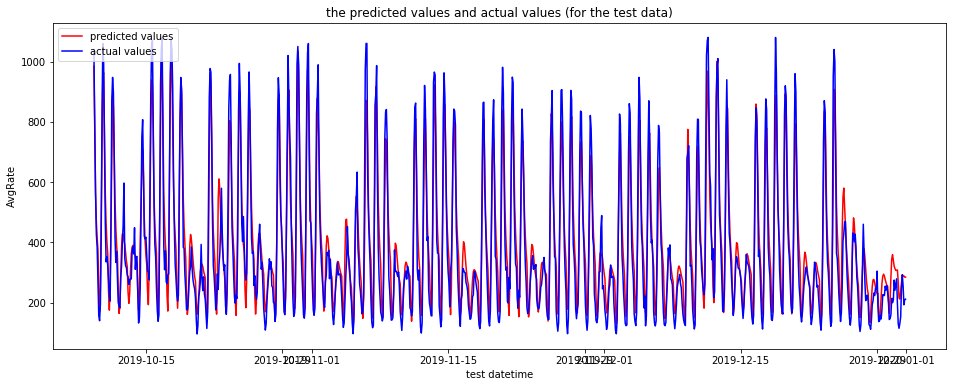

In [32]:
test_date=df[-test_num:].index
plot_predict_actual_values(test_date, y_pred_unscale, y_test_unscale, ylabel=uni_target_value)


### multivariate forecasting 

We use MTNet model as an example for multivariate forecasting.

In [33]:
from zoo.zouwu.model.forecast import MTNetForecaster

In [37]:
mtnet_forecaster = MTNetForecaster(horizon=y_train_m.shape[-1],
                        feature_dim=x_train_m.shape[-1],
                        lb_long_steps=6,
                        lb_long_stepsize=12
    )

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
# mtnet requires reshape of input x before feeding into model.
x_train_mtnet = mtnet_forecaster.preprocess_input(x_train_m)
x_test_mtnet = mtnet_forecaster.preprocess_input(x_test_m)

In [ ]:
%%time
hist = mtnet_forecaster.fit(x = x_train_mtnet, y = y_train, batch_size=1024, epochs=20)

Train on 7675 samples
Epoch 1/20
7675/7675 [==============================] - 22s 3ms/sample - loss: 0.8297 - mean_squared_error: 1.0801
Epoch 2/20
7675/7675 [==============================] - 11s 1ms/sample - loss: 0.7825 - mean_squared_error: 1.0194
Epoch 3/20
7675/7675 [==============================] - 11s 1ms/sample - loss: 0.7474 - mean_squared_error: 1.0155
Epoch 4/20
7675/7675 [==============================] - 11s 1ms/sample - loss: 0.7265 - mean_squared_error: 0.9890
Epoch 5/20
7675/7675 [==============================] - 11s 1ms/sample - loss: 0.7005 - mean_squared_error: 0.9155
Epoch 6/20
7675/7675 [==============================] - 11s 1ms/sample - loss: 0.6676 - mean_squared_error: 0.8575
Epoch 7/20
7675/7675 [==============================] - 11s 1ms/sample - loss: 0.6270 - mean_squared_error: 0.7974
Epoch 8/20
7675/7675 [==============================] - 11s 1ms/sample - loss: 0.5670 - mean_squared_error: 0.6893
Epoch 9/20
7675/7675 [==============================] - 11

In [ ]:
y_pred_m = mtnet_forecaster.predict(x_test_mtnet)

In [ ]:
y_pred_m_unscale = unscale(standard_scaler, y_pred_m, multi_target_col_indexes)
y_test_m_unscale = unscale(standard_scaler, y_test_m, multi_target_col_indexes)

In [ ]:
# evaluate with sMAPE
sMAPE(y_pred_m_unscale, y_test_m_unscale)

In [ ]:
test_date=df[-test_num:].index
plot_predict_actual_values(test_date, y_pred_m_unscale[:,0], y_test_m_unscale[:,0], ylabel=multi_target_value[0])

In [ ]:
plot_predict_actual_values(test_date, y_pred_m_unscale[:,1], y_test_m_unscale[:,1], ylabel=multi_target_value[1])